## Deep Q Learning: A Deep Reinforcement Learning Algorithm

In week six, we computed Q-valeus for the Cartpole problem using a gridded state space that allowed the state space to be stored as a large table in computer memory. When you can enumerate the state space in computer memory, you can compute a so-called tabular solution for the Q-learning problem. The solution is held in computer memory. 

In week seven, neural networks were shown to be able to approximate functions. This observation suggests using a neural network to approximate the Q-function. Deep learning techniques that approximate the Q-function are called Deep Q-Networks, or DQN.

For the neural network problem, we first created a set of data to create the neural network. This presents a problem for the Q-learning problem. We can use the state-action pairs as inputs to the neural network, but we do not have desired outputs. They are incrementally computed using the Q update equation. This means that the Q-values and target values are correlated, and the targets are non-stationary. The neural network architecture and updates become more complex to mitigate these concerns. 

DQN implementations contain two additional components - an experience replay buffer and a target network. The experience replay buffer holds previously experiences and the target network is used to update the Q-values. This [Medium article](https://arshren.medium.com/deep-q-learning-a-deep-reinforcement-learning-algorithm-f1366cf1b53d) discusses these ideas and provides an implementation of the DQN algorithm using PyTorch. (I have updated the code to work with the newer gymnasium environments.)

There are are two things you might consider testing. First, in the fifth cell are a number of hyper parameters. You can change the number of hidden nodes for the neural networks. The batch size for training can also be changed. This is the number of experiences sampled from the replay buffer when learning. Second, in the last cell you can change the number of training episodes. This can be easily found in the code and is currently set to 500. There is a modulus calculation around the print statement near the end of the cell to lessen the ouput to every 20 episodes. Change this as you see fit for your experiments. My experience is that runtimes for training the neural networks is somwhere between 3-10 minutes.

One last thing to observe is you CPU usage during training. PyTorch parallilzes the training process across GPUs. But it also does this across your CPU cores. You should see a significant increase in CPU usage for all of the CPU cores on your machine.

Below are the needed imports.

In [1]:
# importing required libraries
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython import display

This cell sets up the matplotlib environment as well as the PyTorch environment.

In [2]:
plt.ion()

# setting the device
# if gpu is to be used for Mac OS
# device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
# if gpu is to be used for cuda
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


This class is used to create the experience replay buffer.

In [3]:
# structure of the Experiences to store
Experience= namedtuple('Experience', 
('state', 'action', 'next_state', 'reward'))

# stores the Experience Replay buffer
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory= deque([], maxlen=capacity)
    
    def push(self, *args):
        
        # Save the Experience into memory 
        self.memory.append(Experience(*args))
    
    def sample(self, batch_size):
        
        #selecting a random batch of Experience for training
        return random.sample(self.memory,batch_size)
    
    def __len__(self):
        return len(self.memory)

This class is used to create the two neural networks - the policy network and the target network.

In [4]:
"""Simple MLP network."""
class DQN(nn.Module):
    """
        Args:
            n_observations: observation/state size of the environment
            n_actions: number of discrete actions available in the environment
            hidden_size: size of hidden layers
        """
    def __init__(self, n_observations, n_actions, hidden_size):
        super(DQN, self).__init__()
        self.layer1= nn.Linear(n_observations, hidden_size)
        self.layer2= nn.Linear(hidden_size, hidden_size)
        self.layer3= nn.Linear( hidden_size, n_actions)
    def forward(self,x):
        x=F.relu(self.layer1(x))
        x=F.relu(self.layer2(x))
        return self.layer3(x)

These are the hyperparamaters for the DQN.

In [5]:
BATCH_SIZE = 128      # BATCH_SIZE is the number of Experience sampled from the replay buffer
GAMMA = 0.99          # GAMMA is the discount factor as mentioned in the previous section
EPSILON_START = 0.9   # EPSILON_START is the starting value of epsilon
EPSILON_END = 0.05    # EPSILON_END is the final value of epsilon
EPSILON_DECAY = 1000  # EPSILON_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005           # TAU is the update rate of the target network
LR = 1e-4             # LR is the learning rate of the AdamW optimizer
HIDDEN_SIZE=128       # the hidden layers in the DQN

This is a funciton to do epsilon greedy. Note that the value of epsilon is not constant. Early on, a larger value of epsilon is used to explore. Later, the value of epsilon decays toward zero. 

In [6]:
def choose_action(state):
    global steps_done
    sample= random.random()
    epsilon_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done / EPSILON_DECAY)
    
    steps_done+=1
    if sample>epsilon_threshold:
        # max(1) will return largest column value of each row.
        # second column on max result is index of where max element was found
        # so we pick action with the larger expected reward.
        with torch.no_grad():
            return policy_network(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]],device=device, dtype= torch.long )

The function is used for plotting the durations of episodes.

In [7]:
'''
Function to plot the durations of episodes, 
along with an average over the last 100 episodes
'''
def plot_scores(show_result=False):
    plt.figure(1)
    duration_t= torch.tensor(episode_duration, dtype= torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(duration_t.numpy())
    # Take 100 episode averages and plot them too
    if len(duration_t) >= 100:
        means = duration_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated
    if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
    else:
            display.display(plt.gcf())

This function performs the optimization step of the DQN.

In [8]:
#function that performs a single step of the optimization
def optimize_model():
    if len(memory)<BATCH_SIZE:
        return
    transition= memory.sample(BATCH_SIZE)
    
    '''
    # Transpose the batch and convert the  batch-array of Experience
    # to Transition of batch-arrays
    '''
    batch=Experience(*zip(*transition))
    
    #Compute a mask of non-final states and concatenate the batch element
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch=torch.cat(batch.state)
    action_batch=torch.cat(batch.action)
    reward_batch=torch.cat(batch.reward)
    
    # Compute Q(s_t, a)
    #These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values= policy_network(state_batch).gather(1,action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    next_state_values=torch.zeros(BATCH_SIZE,device=device)
    
    with torch.no_grad():
        next_state_values[non_final_mask]= target_network(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values= reward_batch + (GAMMA* next_state_values)
    
    # Compute Huber loss
    criterion=nn.SmoothL1Loss()
    loss=criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    
    #optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_network.parameters(),100)
    optimizer.step()

This is the main loop for training the DQN. Just above the first for loop the the number of training episodes is set.

Note the instatiation of the environment. (For the ambitious, you may be able to change the environment to other gymnasium environments.)

Note the instantiation of the policy network, the target network, and the experience replay memory.

Episode 0 Game terminated after 14 steps with reward tensor([15.])
Episode 20 Game terminated after 20 steps with reward tensor([21.])
Episode 40 Game terminated after 12 steps with reward tensor([13.])
Episode 60 Game terminated after 13 steps with reward tensor([14.])
Episode 80 Game terminated after 12 steps with reward tensor([13.])
Episode 100 Game terminated after 7 steps with reward tensor([8.])
Episode 120 Game terminated after 14 steps with reward tensor([15.])
Episode 140 Game terminated after 12 steps with reward tensor([13.])
Episode 160 Game terminated after 128 steps with reward tensor([129.])
Episode 180 Game terminated after 129 steps with reward tensor([130.])
Episode 200 Game terminated after 156 steps with reward tensor([157.])
Episode 220 Game terminated after 166 steps with reward tensor([167.])
Episode 240 Game terminated after 179 steps with reward tensor([180.])
Episode 260 Game terminated after 165 steps with reward tensor([166.])
Episode 280 Game terminated af

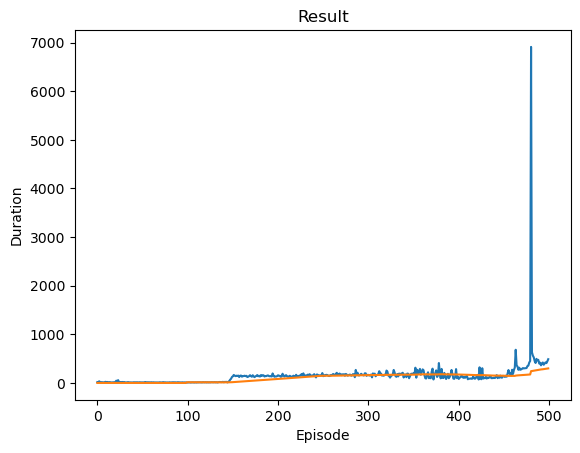

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:

env = gym.make('CartPole-v1') ## added by Doug 

# Get number of actions from gym action space
n_actions= env.action_space.n
state,_ = env.reset() ## modified by Doug for new gymnasium environment
n_observations= len(state)

policy_network = DQN(n_observations, n_actions, HIDDEN_SIZE).to(device)
target_network = DQN(n_observations, n_actions, HIDDEN_SIZE).to(device)
#updates the parameters of the target network  with the parameters of the policy network 
target_network.load_state_dict(policy_network.state_dict())

optimizer=optim.AdamW(policy_network.parameters(), lr=LR, amsgrad=True)
memory= ReplayMemory(10000)
steps_done=0
episode_duration=[]

num_episodes = 500 ## number of training episodes to run

for i in range(num_episodes):
    #At the beginning we reset the environment and 
    #initialize the state Tensor.
    state,_ = env.reset() ## modified by Doug for new gymnasium environment
    state=torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward =0
    for t in count():
        #sample an action
        action = choose_action(state)
        #execute it, observe the next screen and the reward 
        observation, reward, terminated, _, _ = env.step(action.item()) ## modified by Doug for new gymnasium environment
        reward = torch.tensor([reward], device=device)
        done = terminated 

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            
        # Store the experience in the memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the policy network)
        #The agent  performs an optimization step on the Policy Network using the stored memory
        optimize_model()

        '''
        The agent will perform a soft update of the Target Network's weights, 
        with the equation TAU * policy_net_state_dict + (1-TAU) * target_net_state_dict, 
        this helps to make the Target Network's weights converge to the Policy Network's weights.
        '''
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        #policy_network.state_dict() returns the parameters of the policy network
        #target_network.load_state_dict() loads these parameters into the target network.
        target_net_state_dict = target_network.state_dict()
        policy_net_state_dict = policy_network.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_network.load_state_dict(target_net_state_dict)
        total_reward += reward
        if done:
            episode_duration.append(t + 1)
            if i%20 == 0:
                print("Episode", i,"Game terminated after", t, "steps with reward", total_reward)
            
            break
        
print('Complete')
plot_scores(show_result=True)
plt.ioff()
plt.show()